### PbLi Simple

In [1]:
import openmc
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator, ScalarFormatter
from scipy.interpolate import make_interp_spline
import imageio.v2 as iio # use v2 to avoid deprecation warnings --ppark

# Import helper functions
sys.path.insert(0, f"{Path.cwd()}/helper")
from utilities import *

MASS_U_LIST = [0, 0.1, 1, 5, 10, 20, 30, 40, 50] # metric tons uranium (MTU)
n_cells = len(MASS_U_LIST)

ENRICH_LI = 90  

Don't run the `sp = openmc.StatePoint(...)` if you plan on running OpenMC that modifies the same directory. The `openmc.StatePoint` opens the `statepoint.100.h5` and prevents OpenMC from writing to it. So, your OpenMC will run but only to fail at the very end with:
``` 
ERROR: Failed to open HDF5 file with mode ‘w’: summary.h5 
```
If you did run into this error, close the Jupyter notebook instance(s) in `cmd` or `Terminal` and restart them.

In [4]:
""" Load tallies """
sp = openmc.StatePoint(f'./model_PbLi_Li90/statepoint.25.h5') 

# Make directories for figures 
for sd in ['pdf','png','gif']:
    os.makedirs(f'./figures/{sd}/PbLi_Li90/', exist_ok=True)

In [5]:
""" Convert tallies into usable forms """
# Read tallies
flux_tally = sp.get_tally(name='flux')
U_tally    = sp.get_tally(name='uranium rxn rates')
Li_tally   = sp.get_tally(name='lithium rxn rates')
Pb_tally    = sp.get_tally(name='lead rxn rates') 

# Sum over energy bins for total reaction rates
Li6_rxn_rates = Li_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['Li6'], remove_filter=True)
Li7_rxn_rates = Li_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['Li7'], remove_filter=True)
Pb_rxn_rates = Pb_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['Pb204', 'Pb206', 'Pb207', 'Pb208'], remove_filter=True)
U235_rxn_rates = U_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['U238'], remove_filter=True)
U238_rxn_rates = U_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['U238'], remove_filter=True)
# print(Li6_rxn_rates.get_pandas_dataframe())

# Convert Tally objects into pandas dataframes
flux_df = flux_tally.get_pandas_dataframe() # Convert Tally object! Not 'XXX_rxn_rates'! --ppark
U_df    = U_tally.get_pandas_dataframe()
Li_df   = Li_tally.get_pandas_dataframe()
Pb_df   = Pb_tally.get_pandas_dataframe()

# Add new column for energy bin midpoint (for plotting) 
flux_df['energy mid [eV]'] = (flux_df['energy low [eV]'] + flux_df['energy high [eV]']) / 2
U_df['energy mid [eV]'] = (U_df['energy low [eV]'] + U_df['energy high [eV]']) / 2
Li_df['energy mid [eV]'] = (Li_df['energy low [eV]'] + Li_df['energy high [eV]']) / 2
Pb_df['energy mid [eV]'] = (Pb_df['energy low [eV]'] + Pb_df['energy high [eV]']) / 2

cell_ids = U_df['cell'].unique().tolist()
# print(flux_df)

#### Plotting the TBR

[1.6711095442636985, 1.6703697927830803, 1.6712451376952693, 1.673255365722159, 1.6754927165265268, 1.6800711498477416, 1.684748025386081, 1.690482351482258, 1.6944832627735864]


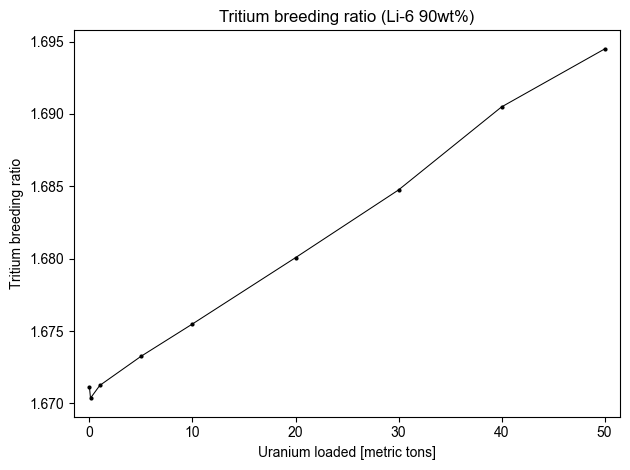

In [7]:
Li6_df = Li6_rxn_rates.get_pandas_dataframe()
Li7_df = Li7_rxn_rates.get_pandas_dataframe()
Li6_nt_df = Li6_df[Li6_df['score'] == '(n,Xt)'][['cell', 'mean', 'std. dev.']]
Li7_nt_df = Li7_df[Li6_df['score'] == '(n,Xt)'][['cell', 'mean', 'std. dev.']]

# print(Li6_nt_df, Li7_nt_df)

tbr_list     = [x + y for x, y in zip(Li6_nt_df['mean'].tolist(), Li7_nt_df['mean'].tolist())]
tbr_err_list =[x + y for x, y in zip(Li6_nt_df['std. dev.'].tolist(), Li7_nt_df['std. dev.'].tolist())]
# tbr_list = Li6_rxn_rates.get_values(scores=['(n,t)'],value='mean').flatten().tolist() # same thing but I'm more familiar with pandas rn --ppark 2025-07-05
print(tbr_list)
plt.figure()
plt.errorbar(MASS_U_LIST, tbr_list, yerr=tbr_err_list, fmt='o-', markersize=2, capsize=0, linewidth=0.75, color='#000000',) # turn capsize > 0 to show error bars, but they're super smol
plt.xlim(-1.5,51.5)
# plt.ylim(1.7,1.9)
# plt.ylim(1.07095,1.0845)
plt.title(f'Tritium breeding ratio (Li-6 {ENRICH_LI}wt%)')
plt.xlabel('Uranium loaded [metric tons]')
plt.ylabel('Tritium breeding ratio')
plt.tight_layout()

plt.savefig(f'./figures/pdf/PbLi/fig_tbr.pdf', bbox_inches='tight', format='pdf')
plt.savefig(f'./figures/png/PbLi/fig_tbr.png', bbox_inches='tight', format='png')
plt.show()

#### Plutonium production rate

[0.0, 8.97474537077207e-05, 0.0008987804415832726, 0.0045185219628147985, 0.009100506070846366, 0.018447184521542676, 0.02805224166798383, 0.037937391666988764, 0.04805366261029907]


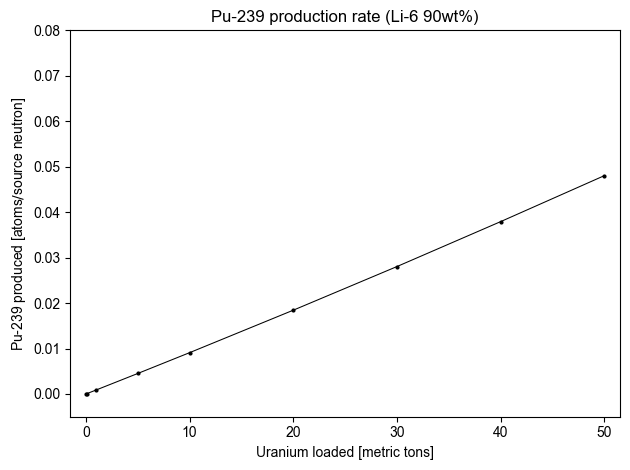

In [10]:
U238_df = U238_rxn_rates.get_pandas_dataframe()
U238_abs_df = U238_df[U238_df['score'] == '(n,gamma)'][['cell', 'mean', 'std. dev.']]
Pu_list, Pu_err_list = U238_abs_df['mean'].tolist(), U238_abs_df['std. dev.'].tolist()
print(Pu_list) # for debug --ppark 2025-07-05

plt.figure()
plt.errorbar(MASS_U_LIST, Pu_list, yerr=Pu_err_list, fmt='o-', markersize=2, capsize=0, linewidth=0.75, color='#000000',) # turn capsize > 0 to show error bars, but they're super smol
plt.xlim(-1.5,51.5)
plt.ylim(-0.005,0.080)

plt.title(f'Pu-239 production rate (Li-6 {ENRICH_LI}wt%)')
plt.xlabel('Uranium loaded [metric tons]')
plt.ylabel(r'Pu-239 produced [atoms$/$source neutron]')
plt.tight_layout()

plt.savefig(f'./figures/pdf/PbLi/fig_Pu.pdf', bbox_inches='tight', format='pdf')
plt.savefig(f'./figures/png/PbLi/fig_Pu.png', bbox_inches='tight', format='png')
plt.show()

#### Plutonium production rate per MTU

[0.000897474537077207, 0.0008987804415832726, 0.0009037043925629598, 0.0009100506070846366, 0.0009223592260771338, 0.0009350747222661277, 0.0009484347916747191, 0.0009610732522059815]


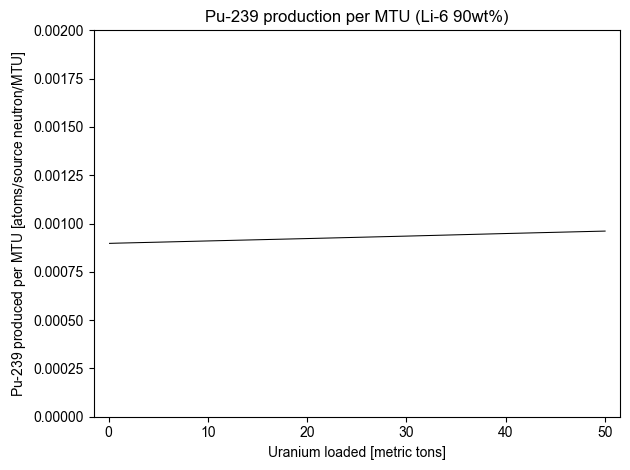

In [9]:
'''fix this here, previously it was Pu_list[i], but i was 0, 1, 2 ,3... while m started from index 1
this was done to not plot the 0 mass value and avoid a divide by 0 error but you need i+1 for the index to match
the mass list we are using --Emma 7/9'''

Pu_per_mtu_list = []
for i, m in enumerate(MASS_U_LIST[1:]):
    Pu_per_mtu_list.append(Pu_list[i+1]/m)
print(Pu_per_mtu_list) # for debug --ppark 2025-07-05

plt.figure()
plt.plot(MASS_U_LIST[1:], Pu_per_mtu_list, markersize=2, linewidth=0.75, color='#000000',) # turn capsize > 0 to show error bars, but they're super smol
plt.xlim(-1.5,51.5)
plt.ylim(0.0,0.002)
plt.title(f'Pu-239 production per MTU (Li-6 {ENRICH_LI}wt%)')
plt.xlabel('Uranium loaded [metric tons]')
plt.ylabel(r'Pu-239 produced per MTU [atoms$/$source neutron$/$MTU]')
plt.tight_layout()

plt.savefig(f'./figures/pdf/PbLi/fig_Pu.pdf', bbox_inches='tight', format='pdf')
plt.savefig(f'./figures/png/PbLi/fig_Pu.png', bbox_inches='tight', format='png')
plt.show()

### Reaction rates
#### All reaction rates per U loading

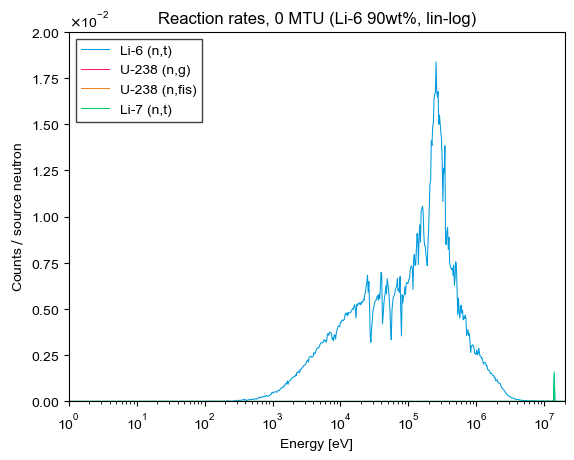

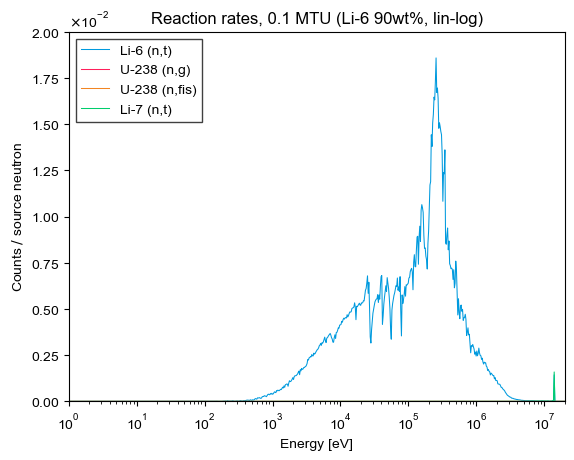

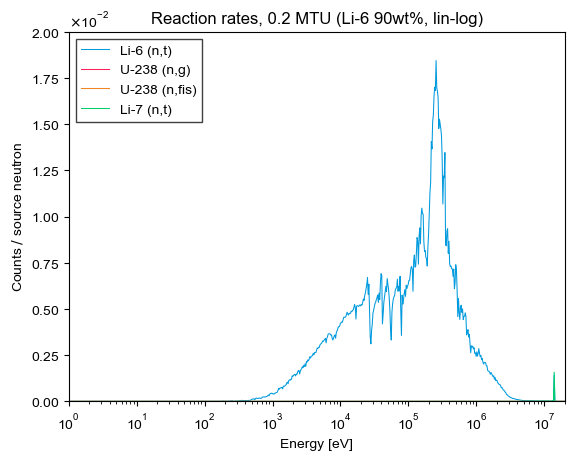

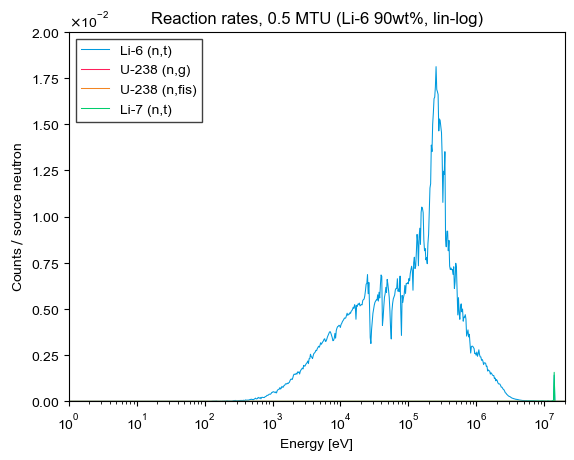

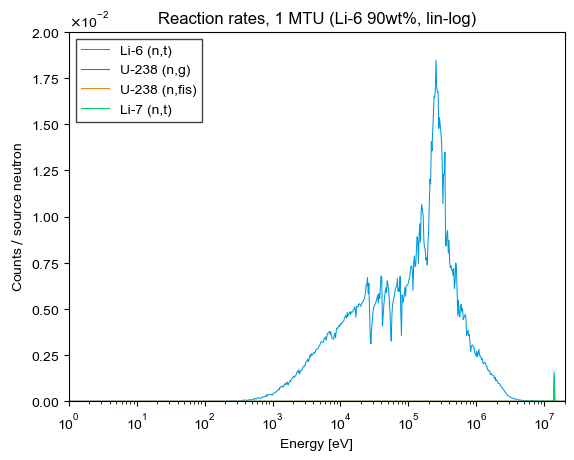

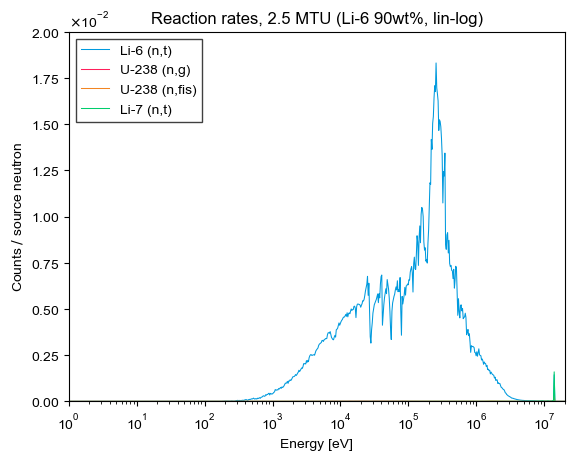

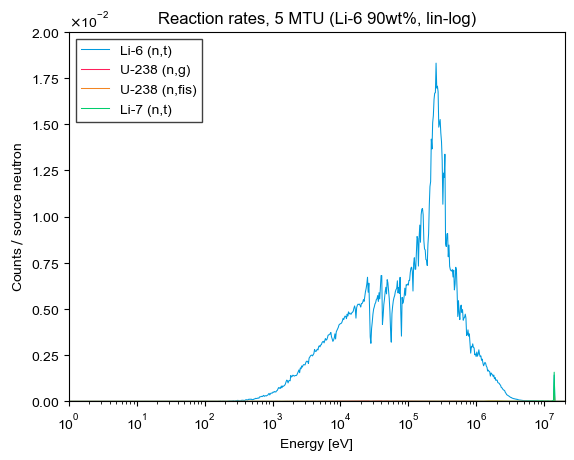

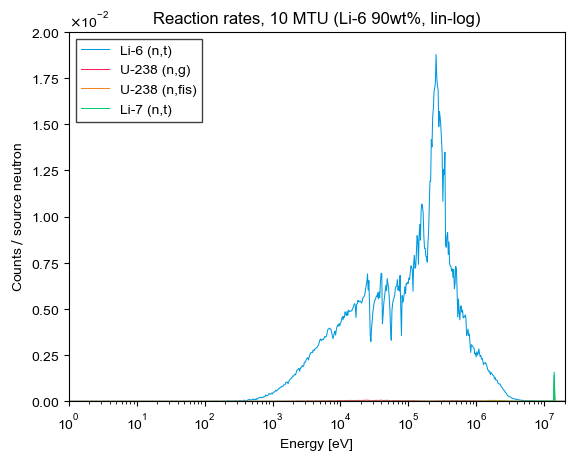

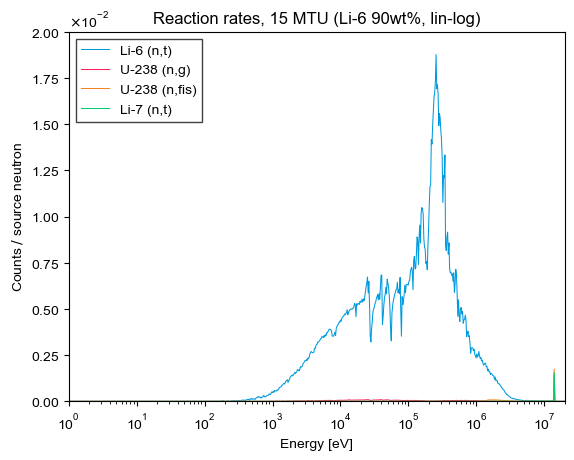

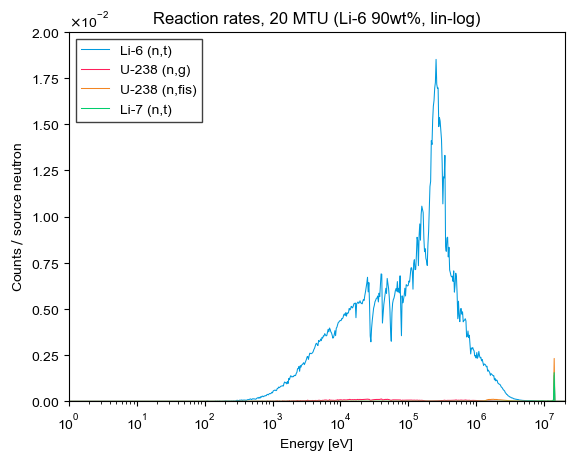

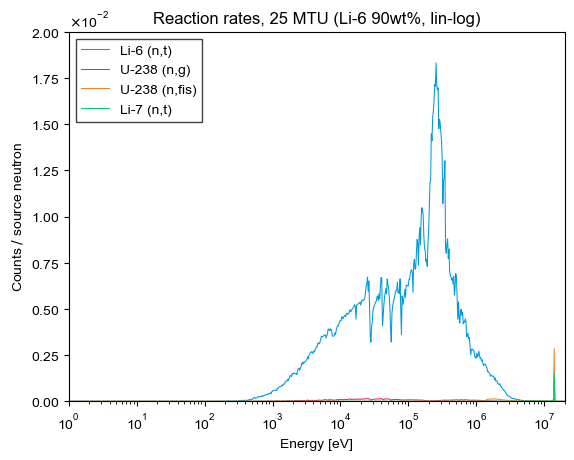

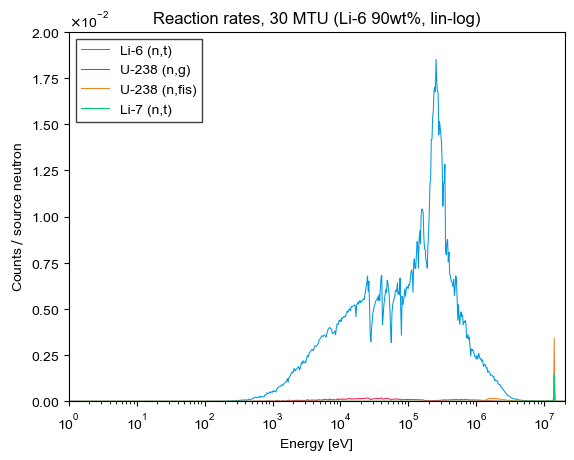

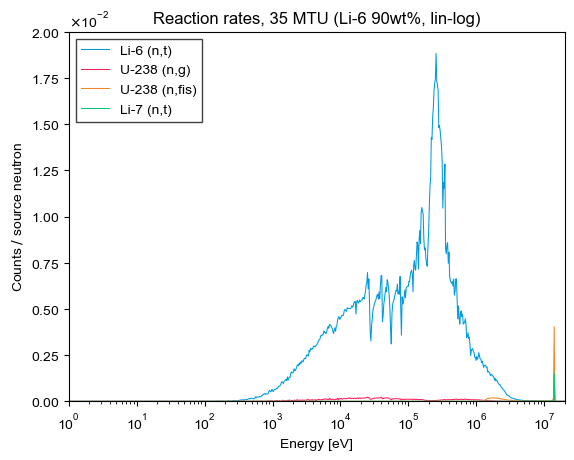

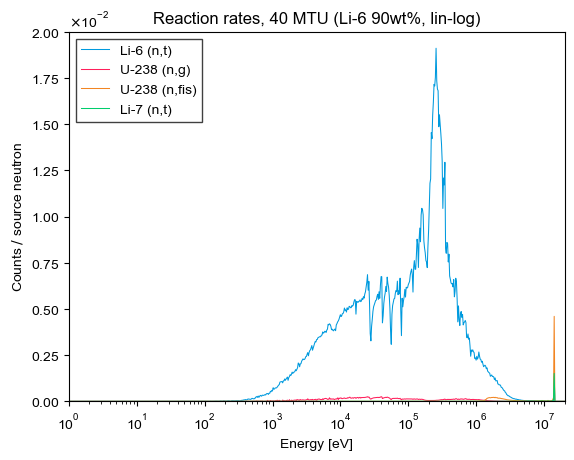

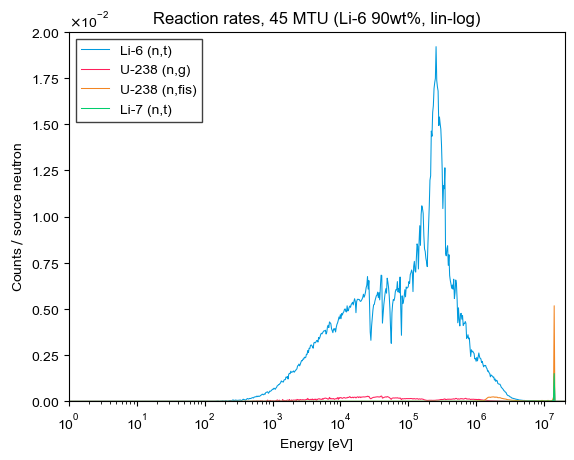

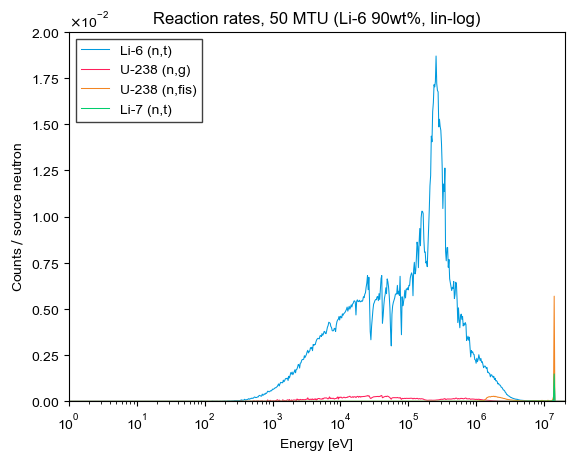

In [38]:
U238_abs_Ebin_df = U_df[(U_df['nuclide'] == 'U238') & (U_df['score'] == '(n,gamma)')][['energy mid [eV]', 'cell', 'mean', 'std. dev.']]
U238_fis_Ebin_df = U_df[(U_df['nuclide'] == 'U238') & (U_df['score'] == 'fission')][['energy mid [eV]', 'cell', 'mean', 'std. dev.']]
Li6_nt_Ebin_df   = Li_df[(Li_df['nuclide'] == 'Li6') & (Li_df['score'] == '(n,Xt)')][['energy mid [eV]', 'cell', 'mean', 'std. dev.']]
Li7_nt_Ebin_df   = Li_df[(Li_df['nuclide'] == 'Li7') & (Li_df['score'] == '(n,Xt)')][['energy mid [eV]', 'cell', 'mean', 'std. dev.']]
Pb_n2n_Ebin_df = Pb_df[(Pb_df['score'] == '(n,2n)')]
Pb_n2n_Ebin_df = Pb_n2n_Ebin_df.groupby(['cell', 'energy mid [eV]'])[['mean', 'std. dev.']].sum().reset_index()

#print(Pb_n2n_Ebin_df)

for i, cell_id in enumerate(cell_ids):
    x = flux_df[(flux_df['cell'] == cell_id)]['energy mid [eV]']
    y_flux     = flux_df[flux_df['cell'] == cell_id]['mean']
    y_U238_ng = U238_abs_Ebin_df[U238_abs_Ebin_df['cell'] == cell_id]['mean']
    y_U238_fis = U238_fis_Ebin_df[U238_fis_Ebin_df['cell'] == cell_id]['mean']
    y_Li6_nt   = Li6_nt_Ebin_df[Li6_nt_Ebin_df['cell'] == cell_id]['mean'] 
    y_Li7_nt   = Li7_nt_Ebin_df[Li7_nt_Ebin_df['cell'] == cell_id]['mean']
    y_Pb_n2n   = Pb_n2n_Ebin_df[Pb_n2n_Ebin_df['cell'] == cell_id]['mean']
    
    plt.figure()
    flux_line, = plt.plot(x, y_flux,     linewidth=0.75, color='#000000', label=r'Flux') # black / flux_line, = is to remove it in lin scale bc it doesn't fit
    plt.plot(x, y_Li6_nt,   linewidth=0.75, color='#009ade', label=r'Li-6 (n,t)') # blue
    plt.plot(x, y_U238_ng, linewidth=0.75, color='#ff1f5b', label=r'U-238 (n,g)') # red
    plt.plot(x, y_U238_fis, linewidth=0.75, color='#f28522', label=r'U-238 (n,fis)') # yellow / #00cd6c = green
    plt.plot(x, y_Li7_nt, linewidth=0.75, color='#00cd6c', label=r'Li-7 (n,t)') # green
    # plt.plot(x, y_Pb_n2n, linewidth=0.75, color='#ffc0cb', label=r'Pb (n,2n)') # pink
    
    plt.xlabel('Energy [eV]')
    plt.ylabel('Counts $/$ source neutron')
    
    
    ''' Export figure in log-log scale ''' 
    plt.title(f'Reaction rates, {MASS_U_LIST[i]} MTU (Li-6 {ENRICH_LI}wt%, log-log)')
    plt.xscale('log'), plt.yscale('log')
    plt.xlim(1e0,2e7), plt.ylim(1e-14,1)

    # Reposition legend
    leg = plt.legend(loc='lower right', ncols=2, frameon=True, fancybox=False, edgecolor='black', framealpha=.75,) # fontsize='small', ncols=1, 
    leg.get_frame().set_linewidth(1)

    # Export figure
    plt.savefig(f'./figures/pdf/PbLi/fig_rxnrates_log_{MASS_U_LIST[i]}mtu.pdf', bbox_inches='tight', format='pdf') 
    plt.savefig(f'./figures/png/PbLi/fig_rxnrates_log_{MASS_U_LIST[i]}mtu.png', bbox_inches='tight', format='png') # you want 'log' before 'mtu' so you can flip thru them in File Explorer

    
    ''' Export figure in log-lin scale '''
    flux_line.remove() # remove flux plot in lin scale bc it doesn't fit
    
    plt.title(f'Reaction rates, {MASS_U_LIST[i]} MTU (Li-6 {ENRICH_LI}wt%, lin-log)')
    plt.xscale('log'), plt.yscale('linear')
    plt.xlim(1e0,2e7), plt.ylim(0,0.02)
    
    # Force scientific notation for y-axis
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # plt.gca().yaxis.set_major_locator(MultipleLocator(0.001)) # force y ticks at every integer

    # Reposition legend
    leg = plt.legend(loc='upper left', ncols=1, frameon=True, fancybox=False, edgecolor='black', framealpha=.75,) # fontsize='small', ncols=1, 
    leg.get_frame().set_linewidth(1)

    # Export figure
    plt.savefig(f'./figures/pdf/PbLi/fig_rxnrates_lin_{MASS_U_LIST[i]}mtu.pdf', bbox_inches='tight', format='pdf')
    plt.savefig(f'./figures/png/PbLi/fig_rxnrates_lin_{MASS_U_LIST[i]}mtu.png', bbox_inches='tight', format='png') # you want 'lin' before 'mtu' so you can flip thru them in File Explorer
    
    del x, y_U238_ng, y_U238_fis, y_Li6_nt, y_Li7_nt, y_Pb_n2n

#### Turn the "Reaction rates per MTU" plots into GIFs!

In [39]:
filepaths_lin, filepaths_log = [], []
for i in MASS_U_LIST:
    filepaths_log.append(f"./figures/png/PbLi/fig_rxnrates_log_{i}mtu.png")
    filepaths_lin.append(f"./figures/png/PbLi/fig_rxnrates_lin_{i}mtu.png")

frames_log = [iio.imread(path) for path in filepaths_log]
frames_lin = [iio.imread(path) for path in filepaths_lin]
iio.mimsave(f"./figures/gif/PbLi/fig_rxnrates_log.gif", frames_log, fps=1, loop=0) # loop=0 : infinite loop
iio.mimsave(f"./figures/gif/PbLi/fig_rxnrates_lin.gif", frames_lin, fps=1, loop=0) # loop=0 : infinite loop

#### Zoom in U-238 (n,$\gamma$) as function of MTU on various energy bins in 3$\times$5 grid

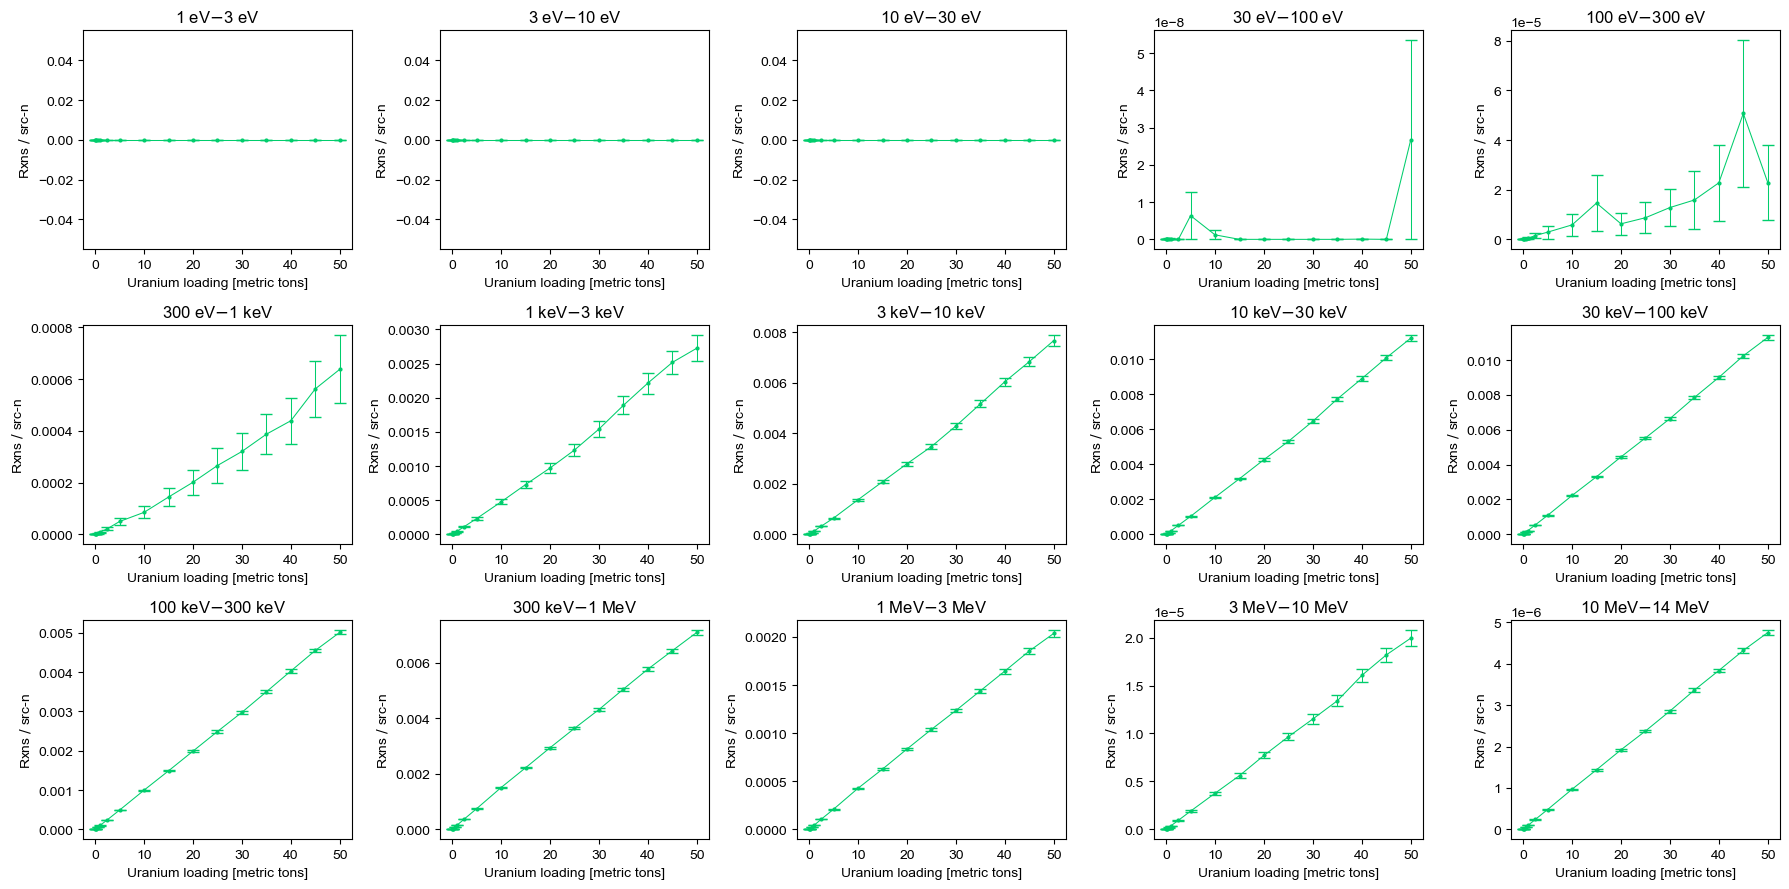

In [40]:
bins_dict = {
    r'1 eV$-$3 eV': (0.9, 3), # r'$--$' doesn't actually return proper en dash :(
    r'3 eV$-$10 eV': (3, 10), 
    r'10 eV$-$30 eV': (10, 30),
    r'30 eV$-$100 eV': (30, 100),
    r'100 eV$-$300 eV': (100, 300),
    r'300 eV$-$1 keV': (300, 1e3),
    r'1 keV$-$3 keV': (1e3, 3e3),
    r'3 keV$-$10 keV': (3e3, 10e3),
    r'10 keV$-$30 keV': (10e3, 30e3),
    r'30 keV$-$100 keV': (30e3, 100e3),
    r'100 keV$-$300 keV': (100e3, 300e3),
    r'300 keV$-$1 MeV': (300e3, 1e6),
    r'1 MeV$-$3 MeV': (1e6, 3e6),
    r'3 MeV$-$10 MeV': (3e6, 10e6),
    r'10 MeV$-$14 MeV': (10e6, 15e6),  }

""" 
Collate y-axis data 
  U238_abs_Ebin_XY should be a list of length len(MASS_U_LIST), 
  ex: XY = [xy_for_0mtu, xy_for_0.1mtu,..., xy_for_50mtu]
  where each xy_for_*mtu is a df of energies, mean, std. dev. 
"""
U238_abs_Ebin_XY = []
cells = U238_abs_Ebin_df['cell'].unique().tolist()
for c in cells:
    xy_to_add = U238_abs_Ebin_df[U238_abs_Ebin_df['cell'] == c][['energy mid [eV]','mean','std. dev.']]
    U238_abs_Ebin_XY.append(xy_to_add)

df_runs = {
    mass: df_mass
    for mass, df_mass in zip(MASS_U_LIST, U238_abs_Ebin_XY)
}

# Loop over each loading
sum_means = {label: [] for label in bins_dict}
sum_stds  = {label: [] for label in bins_dict}
for mass in MASS_U_LIST:
    dfm = df_runs[mass]
    # Loop over each energy bin
    for label, (emin, emax) in bins_dict.items():
        mask = dfm['energy mid [eV]'].between(emin, emax)
        sum_means[label].append(dfm.loc[mask, 'mean'].sum())
        sum_stds[label].append(dfm.loc[mask, 'std. dev.'].sum())

# TODO: Write this more elegantly with Tally.summation() and Tally.get_slice() lol --ppark
# U_tally.get_slice(nuclides=['U238'],scores=['(n,gamma)'], filters=[openmc.CellFilter,openmc.EnergyFilter], filter_bins=[(1,16),((1,3),)])

""" Plot """
# Prepare subplots: 3 rows x 5 columns for 15 bins
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18,9))
axes = axes.flatten()

for ax, (label, (emin, emax)) in zip(axes, bins_dict.items()):
    ax.errorbar(MASS_U_LIST, sum_means[label], yerr=sum_stds[label], fmt='o-', markersize=2, capsize=4, linewidth=0.75, color='#00cd6c',) # turn capsize > 0 to show error bars, but they're super smol
    ax.set_title(label) #,fontsize=24)
    ax.tick_params(axis='both', which='major',) # labelsize=24)
    ax.set_xlabel('Uranium loading [metric tons]')
    ax.set_ylabel('Rxns $/$ src-n')

# Export figure
fig.tight_layout() # you need this here
plt.savefig(f'./figures/pdf/PbLi/fig_u238ng_grid.pdf', bbox_inches='tight', format='pdf')
plt.savefig(f'./figures/png/PbLi/fig_u238ng_grid.png', bbox_inches='tight', format='png') 
plt.show()

In [ ]:
U238_abs_FLUXbin_XY = []
for c in cells:
    flux_xy_to_add = flux_df[flux_df['cell'] == c][['energy mid [eV]','mean','std. dev.']]
    U238_abs_FLUXbin_XY.append(flux_xy_to_add)

df_runs = {
    mass: df_mass
    for mass, df_mass in zip(MASS_U_LIST, U238_abs_FLUXbin_XY)
}

# Loop over each loading
sum_means_F = {label: [] for label in bins_dict}
sum_stds_F  = {label: [] for label in bins_dict}
for mass in MASS_U_LIST:
    dfm = df_runs[mass]
    # Loop over each energy bin
    for label, (emin, emax) in bins_dict.items():
        mask = dfm['energy mid [eV]'].between(emin, emax)
        sum_means_F[label].append(dfm.loc[mask, 'mean'].sum())
        sum_stds_F[label].append(dfm.loc[mask, 'std. dev.'].sum())

# TODO: Write this more elegantly with Tally.summation() and Tally.get_slice() lol --ppark
# U_tally.get_slice(nuclides=['U238'],scores=['(n,gamma)'], filters=[openmc.CellFilter,openmc.EnergyFilter], filter_bins=[(1,16),((1,3),)])

""" Plot """
# Prepare subplots: 3 rows x 5 columns for 15 bins
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18,9))
axes = axes.flatten()

for ax, (label, (emin, emax)) in zip(axes, bins_dict.items()):
    ax.errorbar(MASS_U_LIST, sum_means_F[label], yerr=sum_stds_F[label], fmt='o-', markersize=2, capsize=4, linewidth=0.75, color='#00cd6c',) # turn capsize > 0 to show error bars, but they're super smol
    ax.set_title(label,fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('Uranium loading [metric tons]', fontsize=12)
    ax.set_ylabel('Summed Flux $/$ src-n', fontsize=12)

# Export figure
fig.tight_layout() # you need this here
plt.savefig(f'./figures/pdf/PbLi/fig_sumflux_grid.pdf', bbox_inches='tight', format='pdf')
plt.savefig(f'./figures/png/PbLi/fig_sumflux_grid.png', bbox_inches='tight', format='png') 
plt.show()

In [ ]:
thinbins = np.logspace(-1, np.log10(14e6), 500)  # from 0.1 eV to 14 MeV, 500 bins

# Initialize figure
plt.figure(figsize=(10,7))

# Get a colormap with as many colors as mass loadings
colors = cm.rainbow(np.linspace(0, 1, len(MASS_U_LIST)))
for mass, color, cell_id in zip(MASS_U_LIST, colors, cell_ids):
    energies = flux_df[(flux_df['cell'] == cell_id)]['energy mid [eV]']
    weight = U238_abs_Ebin_df[U238_abs_Ebin_df['cell'] == cell_id]['mean']
    
    # Plot cumulative normalized histogram
    plt.hist(energies, bins=thinbins, weights=weight, alpha=0.4, color=color, edgecolor=None, density=True, cumulative=True,
             label=f'{mass} mtu')

# Final plot formatting
plt.title('Integrated and Normalized U-238 SMOOTH radiative capture spectrum\nfor various uranium loadings')
plt.xlabel('Energy (eV)')
plt.ylabel('Counts Distributed (Normalized)')
plt.xscale('log')
plt.ylim(0, 1)
plt.xlim(0.1, 14e6)
plt.minorticks_on()
plt.grid(True, which='both', ls='--', lw=0.5)

# Legend
plt.legend(title='U loading', fontsize=8, loc='best')

# Save and show
plt.tight_layout()
plt.savefig(f'./figures/png/PbLi/u238_capture_cumulative_all.png', dpi=300)
plt.show()